## Import Packages

In [173]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split 
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion 

from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import (
StandardScaler,
MinMaxScaler,
OneHotEncoder,
OrdinalEncoder
)

from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers.winsorizer import Winsorizer

import mlflow 

from sklearn.metrics import(
accuracy_score,
precision_score,
recall_score,
f1_score
)

from sklearn.metrics import ConfusionMatrixDisplay

## Load the dataset

In [174]:
# read the csv file 

df = pd.read_csv('tested.csv')

df.head

<bound method NDFrame.head of      PassengerId  Survived  Pclass  \
0            892         0       3   
1            893         1       3   
2            894         0       2   
3            895         0       3   
4            896         1       3   
..           ...       ...     ...   
413         1305         0       3   
414         1306         1       1   
415         1307         0       3   
416         1308         0       3   
417         1309         0       3   

                                             Name     Sex   Age  SibSp  Parch  \
0                                Kelly, Mr. James    male  34.5      0      0   
1                Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   
2                       Myles, Mr. Thomas Francis    male  62.0      0      0   
3                                Wirz, Mr. Albert    male  27.0      0      0   
4    Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1   
..                         

In [175]:
# Check for missing values 

(
    df.isna().sum()
)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [176]:
# info about the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


## Data Cleaning

In [177]:
# columns to be dropped

columns_to_drop = ['passengerid','name','ticket','cabin']

In [178]:
def clean_data(df):
    return (
        df
        .rename(columns=str.lower)
        .drop(columns=columns_to_drop)
        .assign(
            family=lambda df_: df_['sibsp'] + df_['parch']
        )
        .drop(columns=['sibsp', 'parch'])
    )


In [179]:
final_df = clean_data(df)

In [180]:
final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,34.5,7.8292,Q,0
1,1,3,female,47.0,7.0000,S,1
2,0,2,male,62.0,9.6875,Q,0
3,0,3,male,27.0,8.6625,S,0
4,1,3,female,22.0,12.2875,S,2


In [181]:
# shape of cleaned data 

final_df.shape

(418, 7)

In [182]:
final_df.isna().sum()

survived     0
pclass       0
sex          0
age         86
fare         1
embarked     0
family       0
dtype: int64

## EDA 

In [183]:
# Distribution of the target

(
    final_df
    .loc[:,'survived']
    .value_counts(normalize=True)
)

survived
0    0.636364
1    0.363636
Name: proportion, dtype: float64

In [184]:
# boxplot 

def create_boxplot(data,column_name,hue=None):
    sns.boxplot(data=data, y=column_name, hue=hue)

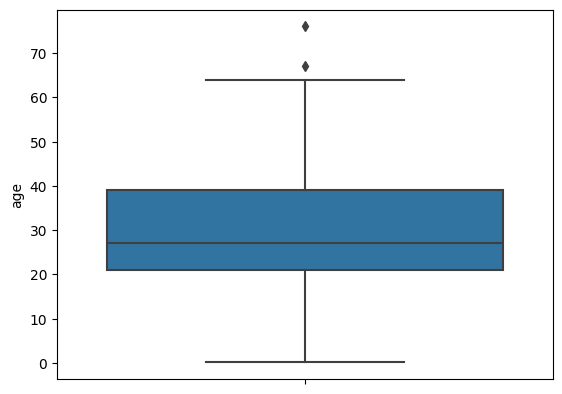

In [185]:
# box plot for age 
create_boxplot(final_df,'age')

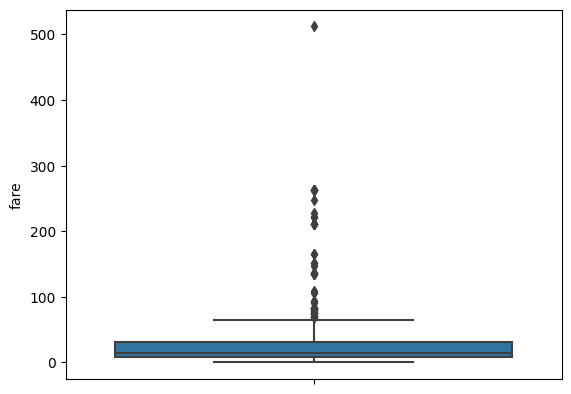

In [186]:
create_boxplot(final_df,'fare')

In [187]:
# plot for distrbution of categorical columns 

def plot_distribution(data,column_name):
    sns.countplot(data=data,x=column_name)

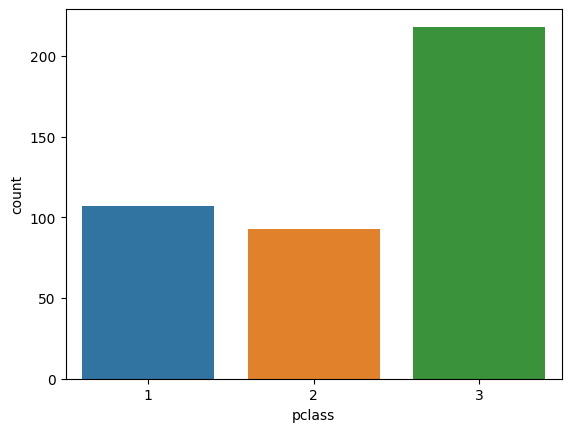

In [188]:
# distribution for p class 
plot_distribution(final_df,'pclass')

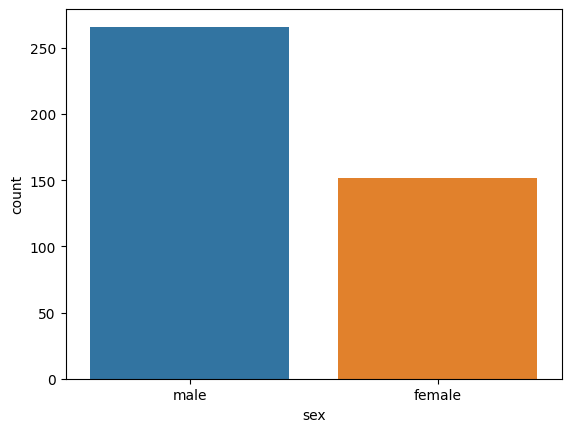

In [189]:
plot_distribution(final_df,'sex')

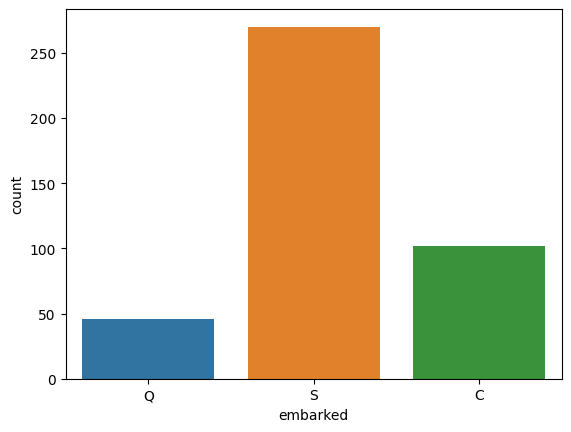

In [190]:
plot_distribution(final_df,'embarked')

## Feature Engineering

In [191]:
final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,34.5,7.8292,Q,0
1,1,3,female,47.0,7.0000,S,1
2,0,2,male,62.0,9.6875,Q,0
3,0,3,male,27.0,8.6625,S,0
4,1,3,female,22.0,12.2875,S,2


In [192]:
# make X and y 

X = final_df.drop(columns=['survived'])
y = final_df['survived']

In [193]:
# do test train split 

X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print("The shape of the training data is" , X_train.shape)
print("The shape of the training data is" , X_test.shape)

The shape of the training data is (334, 6)
The shape of the training data is (84, 6)


## Pipelines for Individual Columns

In [194]:
# age pipeline 

age_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='median')),
    ('outlers',Winsorizer(capping_method='gaussian',fold=3)),
    ('scale',StandardScaler())

])

age_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('outlers', Winsorizer(fold=3)), ('scale', StandardScaler())])

In [195]:
# Modified Fare pipeline to handle missing values
fare_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),  # Add imputation for fare
    ('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
    ('scale', StandardScaler())
])

fare_pipe


Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                ('scale', StandardScaler())])

In [196]:
# Embarked pipeline
embarked_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('count_encode', CountFrequencyEncoder(encoding_method='count')),
    ('scale', MinMaxScaler())
])

embarked_pipe


Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('count_encode', CountFrequencyEncoder()),
                ('scale', MinMaxScaler())])

## Column Transformer

In [197]:
set_config(transform_output='pandas')

In [198]:
preprocessor = ColumnTransformer(transformers=[
    ('age', age_pipe, ['age']),
    ('fare', fare_pipe, ['fare']),
    ('embarked', embarked_pipe, ['embarked']),
    ('sex', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['sex']),
    ('family', MinMaxScaler(), ['family'])
], remainder='passthrough', n_jobs=-1)

# Set output to pandas
from sklearn import set_config
set_config(transform_output='pandas')

# Apply the preprocessor pipeline to the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Check if the missing values are handled correctly
print(X_train_processed.isnull().sum())


age__age              0
fare__fare            0
embarked__embarked    0
sex__sex_female       0
sex__sex_male         0
family__family        0
remainder__pclass     0
dtype: int64


In [199]:
# fit and transform the training data 

preprocessor.fit_transform(X_train)

,age__age,fare__fare,embarked__embarked,sex__sex_female,sex__sex_male,family__family,remainder__pclass
336,0.199182,-0.558653,1.00,0.0,1.0,0.0,2
31,-0.418832,0.261066,1.00,0.0,1.0,0.2,2
84,-0.187077,-0.660197,0.00,0.0,1.0,0.0,2
287,-0.418832,1.941075,1.00,0.0,1.0,0.1,1
317,-0.805091,-0.669426,1.00,0.0,1.0,0.0,2
...,...,...,...,...,...,...,...
71,-0.650587,-0.784816,1.00,0.0,1.0,0.0,3
106,-0.650587,-0.788139,0.00,0.0,1.0,0.0,3
270,1.280707,1.941075,0.25,0.0,1.0,0.0,1
348,-0.418832,-0.536499,1.00,0.0,1.0,0.0,2


In [200]:
preprocessor.get_params(deep=True)

{'force_int_remainder_cols': True,
 'n_jobs': -1,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('age',
   Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                   ('outlers', Winsorizer(fold=3)), ('scale', StandardScaler())]),
   ['age']),
  ('fare',
   Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                   ('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                   ('scale', StandardScaler())]),
   ['fare']),
  ('embarked',
   Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                   ('count_encode', CountFrequencyEncoder()),
                   ('scale', MinMaxScaler())]),
   ['embarked']),
  ('sex',
   OneHotEncoder(handle_unknown='ignore', sparse_output=False),
   ['sex']),
  ('family', MinMaxScaler(), ['family'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'age': Pipeline(steps=[('impute', SimpleImputer(strategy='me

## Model Pipeline 

In [201]:
# build the model pipeline

RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [202]:
model_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [203]:
model_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('clf',RandomForestClassifier(**model_params))

])

model_pipe

/opt/anaconda3/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outlers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold...
                                                                   StandardScaler())]),
                                                  ['fare']),
                                                 ('embarked',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf', RandomForestClassifier(max_depth=10))])

In [204]:
# fit the model 

model_pipe.fit(X_train,y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outlers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold...
                                                                   StandardScaler())]),
                                                  ['fare']),
                                                 ('embarked',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf', RandomForestClassifier(max_depth=10))])

In [205]:
# evaluate the model 

y_pred = model_pipe.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred).item()
recall = recall_score(y_test,y_pred).item()
f1 = f1_score(y_test,y_pred).item()

In [206]:
# metrics dist 

metrics = {
    'accuracy': accuracy,
    'precision':precision,
    'recall':recall,
    'f1_score':f1
}

metrics

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}

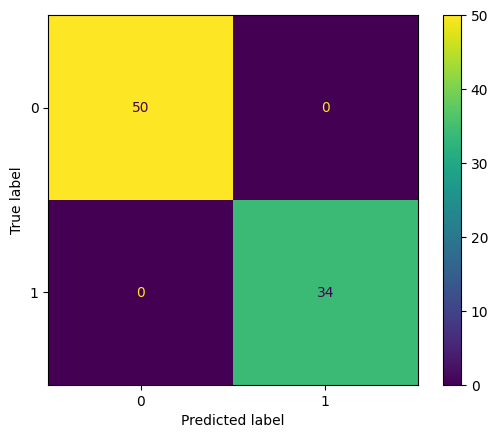

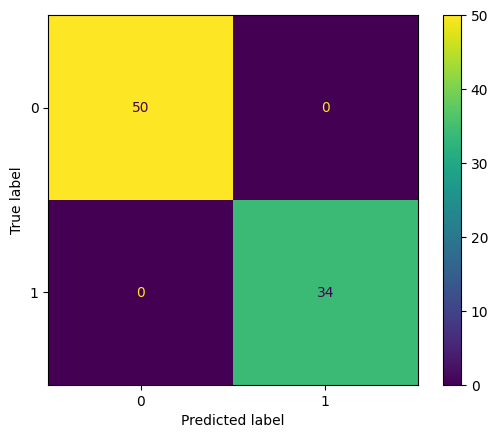

In [207]:
# plot the CM 

cm = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

cm.figure_

## MLFlow Tracking Code 

In [208]:
model_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(n_jobs=-1, remainder='passthrough',
                     transformers=[('age',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='median')),
                                                    ('outlers',
                                                     Winsorizer(fold=3)),
                                                    ('scale', StandardScaler())]),
                                    ['age']),
                                   ('fare',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='median')),
                                                    ('outliers',
                                                     Winsorizer(capping_method='iqr',
                                                                fold=1.5)),
               

In [209]:
X_test.join(y_test)

,pclass,sex,age,fare,embarked,family,survived
321,3,male,25.0,7.2292,C,0,0
324,1,female,39.0,211.3375,S,0,1
388,3,male,21.0,7.7500,Q,0,0
56,3,male,35.0,7.8958,S,0,0
153,3,female,36.0,12.1833,S,2,1
...,...,...,...,...,...,...,...
57,3,male,25.0,7.6500,S,0,0
126,3,male,22.0,7.7958,S,0,0
24,1,female,48.0,262.3750,C,4,1
17,3,male,21.0,7.2250,C,0,0


In [210]:
# check if uri is set 

mlflow.is_tracking_uri_set()

True

**Run all the mlflow related tracking code in a single cell**

2024/09/20 20:30:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/20 20:30:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run third_run at: http://127.0.0.1:8000/#/experiments/283090949613621753/runs/40282488adb04ca7b9bf0b0dcf41602d.
2024/09/20 20:30:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8000/#/experiments/283090949613621753.


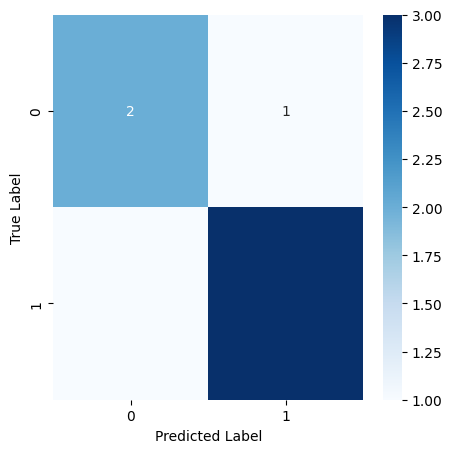

In [211]:
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set the tracking URI to use HTTP instead of HTTPS
mlflow.set_tracking_uri("http://127.0.0.1:8000")

# Set an experiment name
mlflow.set_experiment("Titanic Data")

# Example: Dummy metrics and confusion matrix for logging
y_true = [0, 1, 1, 0, 1, 1, 0]  # Example true values
y_pred = [0, 1, 0, 0, 1, 1, 1]  # Example predicted values
metrics = {
    "accuracy": 0.85,  # Example metric
    "precision": 0.87,
    "recall": 0.88
}

# End any active run if it exists
if mlflow.active_run():
    mlflow.end_run()

# Start logging the run
with mlflow.start_run(run_name="third_run") as run:
    # Log parameters
    mlflow.log_params(model_pipe.get_params())  # Ensure model_pipe is already fitted
    
    # Log metrics (replace 'metrics' with your actual metrics)
    mlflow.log_metrics(metrics)

    # Log the model
    mlflow.sklearn.log_model(sk_model=model_pipe, artifact_path='models')

    # Compute confusion matrix and log as artifact
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    
    # Save the confusion matrix figure
    cm_filename = "confusion_matrix.png"
    fig.savefig(cm_filename)
    
    # Log the confusion matrix as an artifact
    mlflow.log_artifact(cm_filename)
